<a href="https://colab.research.google.com/github/networked-intelligence-lab/QM-MVP/blob/main/notebooks/pipelines/gameemo_pipeline_mistral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NI Lab Repository
This notebook was used for exploratory purposes, and is saved as a Colab notebook in https://github.com/networked-intelligence-lab/QM-MVP under:
```
notebooks/pipelines/gameemo_pipeline_mistral.ipynb
```

---

## Source
### Code
Besides libraries, code is currently entirely self-written (Dax)

### Dataset
Dataset is sourced from the Biomedical Signal Processing and Control Paper titled "**Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO**"

*Citation*: Alakus, T. B., Gonen, M., & Turkoglu, I. (2020). Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO. Biomedical Signal Processing and Control, 60, 101951.

*Kaggle Source*: https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo

## Pre-requisite library installs, dataset loading and extraction

In [1]:
%%sh
apt-get install poppler-utils
pip install pdf2image

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 0s (1,483 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [23]:
%%sh
pip install accelerate
pip install -i https://pypi.org/simple/ bitsandbytes
pip install -q -U git+https://github.com/huggingface/transformers.git
pip install -q -U git+https://github.com/huggingface/peft.git
pip install -q -U git+https://github.com/huggingface/accelerate.git
pip install -q datasets
pip install -q trl

Looking in indexes: https://pypi.org/simple/


In [4]:
%%sh
mkdir ~/.kaggle
cp /content/drive/MyDrive/Tokens/kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
%%sh
kaggle datasets download sigfest/database-for-emotion-recognition-system-gameemo
unzip /content/database-for-emotion-recognition-system-gameemo.zip


Archive:  /content/database-for-emotion-recognition-system-gameemo.zip
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G1AllChannels.csv  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G2AllChannels.csv  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G3AllChannels.csv  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.csv format/S01G4AllChannels.csv  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.mat format/S01G1AllChannels.mat  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.mat format/S01G2AllChannels.mat  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.mat format/S01G3AllChannels.mat  
  inflating: GAMEEMO/(S01)/Preprocessed EEG Data/.mat format/S01G4AllChannels.mat  
  inflating: GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G1AllRawChannels.csv  
  inflating: GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G2AllRawChannels.csv  
  inflating: GAMEEMO/(S01)/Raw EEG Data/.csv format/S01G3AllRawChannels.csv  
  inflating: GAMEEMO/(

100%|██████████| 1.70G/1.70G [00:18<00:00, 96.8MB/s]


## Initial data processing

In [7]:
import os
from glob import glob
import shutil
import pathlib
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from PIL import Image
import json
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Input, concatenate, Reshape
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

In [15]:
import numpy as np
import pywt

def preprocess_eeg_wavelets(X, wavelet='db2', level=8):
    X_wavelets = np.zeros((X.shape[0], X.shape[1], 256))

    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            coeffs = pywt.wavedec(X[i, j], wavelet, level=level)
            coeffs_concat = np.concatenate(coeffs)
            if len(coeffs_concat) > 256:
                coeffs_concat = coeffs_concat[:256]
            else:
                coeffs_concat = np.pad(coeffs_concat, (0, 256 - len(coeffs_concat)), 'constant')
            X_wavelets[i, j] = coeffs_concat

    return X_wavelets

In [8]:
try:
  os.makedirs("data")
except FileExistsError:
  pass

In [9]:
for fileref in pathlib.Path('GAMEEMO/').glob('**/*.csv'):
  fn = str(fileref)
  bn = os.path.basename(fn)
  shutil.copy(fn, f"data/{bn}")

In [10]:
_set = set()

X = []
X_fns = []
for data_fn in glob("data/*AllChannels.csv"):
  X_fn = os.path.basename(data_fn).split("All")[0]
  data_df = pd.read_csv(data_fn)
  data_df = data_df[[c for c in data_df.columns if "unnamed" not in c.lower()]]
  data_np = np.array(data_df).T
  X.append(data_np)
  X_fns.append(X_fn)

In [11]:
X = np.array(X)

In [16]:
X_wavelets = preprocess_eeg_wavelets(X)

In [12]:
print(X.shape)

(112, 14, 38252)


In [18]:
print(X_wavelets.shape)

(112, 14, 256)


In [13]:
print(sorted(X_fns))

['S01G1', 'S01G2', 'S01G3', 'S01G4', 'S02G1', 'S02G2', 'S02G3', 'S02G4', 'S03G1', 'S03G2', 'S03G3', 'S03G4', 'S04G1', 'S04G2', 'S04G3', 'S04G4', 'S05G1', 'S05G2', 'S05G3', 'S05G4', 'S06G1', 'S06G2', 'S06G3', 'S06G4', 'S07G1', 'S07G2', 'S07G3', 'S07G4', 'S08G1', 'S08G2', 'S08G3', 'S08G4', 'S09G1', 'S09G2', 'S09G3', 'S09G4', 'S10G1', 'S10G2', 'S10G3', 'S10G4', 'S11G1', 'S11G2', 'S11G3', 'S11G4', 'S12G1', 'S12G2', 'S12G3', 'S12G4', 'S13G1', 'S13G2', 'S13G3', 'S13G4', 'S14G1', 'S14G2', 'S14G3', 'S14G4', 'S15G1', 'S15G2', 'S15G3', 'S15G4', 'S16G1', 'S16G2', 'S16G3', 'S16G4', 'S17G1', 'S17G2', 'S17G3', 'S17G4', 'S18G1', 'S18G2', 'S18G3', 'S18G4', 'S19G1', 'S19G2', 'S19G3', 'S19G4', 'S20G1', 'S20G2', 'S20G3', 'S20G4', 'S21G1', 'S21G2', 'S21G3', 'S21G4', 'S22G1', 'S22G2', 'S22G3', 'S22G4', 'S23G1', 'S23G2', 'S23G3', 'S23G4', 'S24G1', 'S24G2', 'S24G3', 'S24G4', 'S25G1', 'S25G2', 'S25G3', 'S25G4', 'S26G1', 'S26G2', 'S26G3', 'S26G4', 'S27G1', 'S27G2', 'S27G3', 'S27G4', 'S28G1', 'S28G2', 'S28G3', 

## Manual label curation pipeline

In [ ]:
pdfs = sorted(glob("GAMEEMO/**/*.pdf", recursive=True)) # The following cells is to circumvent input() after display() bugs

In [ ]:
count = 0
labels_dict = {}

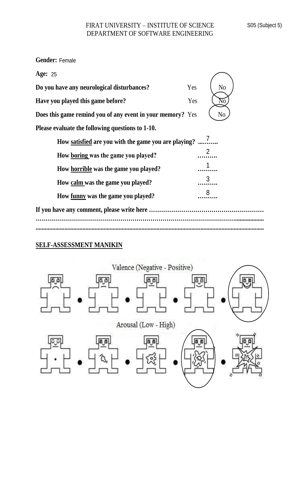

In [ ]:
pdf_fn = pdfs[count]
label_key = pdf_fn
for rem_text in ["GAMEEMO/(", ")/SAM Ratings/", ".pdf"]:
  label_key = label_key.replace(rem_text, '')
images = convert_from_path(pdf_fn)
im = images[0].resize((300, 500))
display(im)

In [ ]:
user_input = input()
labels_dict[label_key] = user_input
count += 1

7 2 1 3 8 5 4


In [ ]:
print(labels_dict)

{'S01G1': '2 8 1 3 2 1.5 2', 'S01G2': '7 2 1 8 8 3 2.5', 'S01G3': '2 2 8 1 1 1.5 5', 'S01G4': '8 1 1 3 9 3 4.5', 'S02G1': '1 8 1 4 2 1 1', 'S02G2': '5 2 1 7 6 3 3', 'S02G3': '2 2 8 3 2 1 5', 'S02G4': '8 2 2 7 9 4 3', 'S03G1': '2 7 2 6 1 1 1.5'}


In [ ]:
print(json.dumps(labels_dict, sort_keys=True, indent=4))

{
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}


## Start of preprocessing and NN

In [19]:
labels_dict = {
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}

In [20]:
y = []
for k, v in labels_dict.items():
  y.append([float(_v) for _v in v.split(' ')])

In [21]:
X_train = X_wavelets[:len(y)]
y_train = np.array(y)

In [22]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_id = "mistralai/Mistral-7B-v0.1"
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

ImportError: Using `bitsandbytes` 8-bit quantization requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes: `pip install -i https://pypi.org/simple/ bitsandbytes`

In [34]:
X_train_tokens = []
for X_rep in X_train:
  channels = []
  for channel in X_rep:
    channels.append(' '.join([str(round(v_, 1)) for v_ in channel]))
  X_train_tokens.append('\n'.join(channels))

In [35]:
print(X_train_tokens)
print(len(X_train_tokens[0]))

['2569.4 2334.5 9.3 32.7 -15.0 -14.3 -7.4 15.9 -3.3 0.6 -107.4 134.7 10.8 -23.9 -13.9 -6.3 -0.5 6.1 -14.8 7.3 -9.0 -23.3 36.5 -2.0 0.1 -2.9 1.0 -7.4 3.6 -0.7 4.7 -4.5 6.3 -3.0 2.6 -10.3 3.3 -3.5 -0.5 -6.0 -0.8 -1.3 -13.4 7.5 -15.4 12.6 -11.3 -3.0 3.9 6.1 10.3 -10.1 4.1 -9.7 2.4 8.4 -10.1 11.6 -8.9 1.9 12.6 2.2 -111.9 58.2 -0.5 9.6 -30.7 77.1 -5.3 -0.8 1.3 -2.7 -2.1 -9.8 32.0 -5.4 1.7 -0.1 -10.9 9.5 -17.1 1.2 30.1 -11.4 7.2 -0.7 4.6 1.7 -3.3 15.3 0.3 0.1 -6.0 -6.2 -0.6 -2.1 5.3 -11.2 12.9 -7.0 -1.0 0.1 13.3 10.0 -4.9 -42.9 -7.1 16.6 -0.9 18.4 -36.9 40.8 -32.1 18.7 -3.1 -1.5 18.2 5.0 -9.3 -6.6 -5.8 -0.7 10.9 14.0 -10.1 -14.0 -17.7 42.9 -31.9 -28.4 36.7 2.0 -55.5 42.8 6.1 -24.9 12.4 -16.3 6.1 -0.4 1.7 12.1 1.8 -16.5 12.5 3.9 -4.3 1.4 -3.1 0.9 8.5 84.3 90.6 -577.1 8.7 -3.1 -25.2 12.6 -25.1 -7.6 0.5 -90.1 163.1 -35.6 30.3 11.9 21.6 15.4 20.6 8.2 2.5 2.4 -13.4 -172.0 -0.6 -5.5 18.1 16.4 -10.7 -2.5 -1.8 -8.7 0.2 6.7 -9.4 -17.3 0.0 13.9 5.9 -10.3 -7.6 -6.5 14.2 20.7 9.4 5.3 17.0 0.1 7.2 2.5 -1

In [32]:
y_train_tokens = []
for y in y_train:
  y_train_tokens.append(' '.join([str(v) for v in y]))

In [33]:
print(y_train_tokens)

['2.0 8.0 1.0 3.0 2.0 1.5 2.0', '7.0 2.0 1.0 8.0 8.0 3.0 2.5', '2.0 2.0 8.0 1.0 1.0 1.5 5.0', '8.0 1.0 1.0 3.0 9.0 3.0 4.5', '1.0 8.0 1.0 4.0 2.0 1.0 1.0', '5.0 2.0 1.0 7.0 6.0 3.0 3.0', '2.0 2.0 8.0 3.0 2.0 1.0 5.0', '8.0 2.0 2.0 7.0 9.0 4.0 3.0', '2.0 7.0 2.0 6.0 1.0 1.0 1.5', '8.0 1.0 1.0 8.0 8.0 4.0 3.0', '9.0 1.0 10.0 1.0 1.0 1.5 5.0', '9.0 1.0 1.0 3.0 9.0 5.0 3.5', '4.0 8.0 1.0 3.0 1.0 1.5 2.5', '7.0 3.0 1.0 9.0 6.0 4.5 4.0', '7.0 1.0 9.0 2.0 1.0 2.0 5.0', '8.0 1.0 1.0 3.0 9.0 3.5 4.0', '3.0 7.0 1.0 2.0 1.0 2.0 2.0', '8.0 2.0 1.0 5.0 7.0 5.0 5.0', '4.0 1.0 8.0 1.0 2.0 1.0 5.0', '7.0 2.0 1.0 3.0 8.0 5.0 4.0']


In [36]:
import pandas as pd
import datasets
from datasets import Dataset, DatasetDict

"""
This will need to be changed to string-flattened representations for both
X_train and y_train.
"""
tdf = pd.DataFrame({"instruction": X_train_tokens, "output": y_train_tokens})
tds = Dataset.from_pandas(tdf)

ds = DatasetDict()
ds['train'] = tds

In [ ]:
def generate_prompt(data_point):
    """Gen. input text based on a prompt, task instruction, (context info.), and answer

    :param data_point: dict: Data point
    :return: dict: tokenzed prompt
    """
    # Samples with additional context into.
    if data_point['input']:
        text = 'Below is an instruction that describes a task, paired with an input that provides' \
               ' further context. Write a response that appropriately completes the request.\n\n'
        text += f'### Instruction:\n{data_point["instruction"]}\n\n'
        text += f'### Input:\n{data_point["input"]}\n\n'
        text += f'### Response:\n{data_point["output"]}'

    # Without
    else:
        text = 'Below is an instruction that describes a task. Write a response that ' \
               'appropriately completes the request.\n\n'
        text += f'### Instruction:\n{data_point["instruction"]}\n\n'
        text += f'### Response:\n{data_point["output"]}'
    return text

# add the "prompt" column in the dataset
text_column = [generate_prompt(data_point) for data_point in data]
data = data.add_column("prompt", text_column)

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj","o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

peft_model = get_peft_model(model, lora_config)
print_trainable_parameters(peft_model)

In [ ]:
model.add_adapter(lora_config, adapter_name="adapter")

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#new code using SFTTrainer
import transformers

from trl import SFTTrainer

tokenizer.pad_token = tokenizer.eos_token
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=test_data,
    dataset_text_field="prompt",
    peft_config=lora_config,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=0.03,
        max_steps=100,
        learning_rate=2e-4,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        save_strategy="epoch",
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

In [ ]:
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

## Inference (WIP)

In [ ]:
sample = X_train[1, :, :]
sample_reshaped = [np.expand_dims(sample[i, :], axis=0) for i in range(n_channels)]

pred = model.predict(sample_reshaped)

1/1 [==============================] - 0s 116ms/step


In [ ]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = ""
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, return_dict=True, load_in_4bit=True, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_id)

In [ ]:
result = get_completion(query="", model=model, tokenizer=tokenizer)
print(result)

In [ ]:
inference_mappings = ["satisfied", "boring", "horrible", "calm", "funny", "positive", "intense"]

top_k = sorted(zip(inference_mappings, pred[0]), key=lambda x: x[1], reverse=True)[:3]
top_emotions = [k[0] for k in top_k]
music_prompt = f"Generate music that exemplifies the emotions of {', '.join(top_emotions[:-1])}, and {top_emotions[-1]}"

In [ ]:
print(music_prompt)

Generate music that exemplifies the emotions of calm, funny, and positive
